In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
from scipy.interpolate import UnivariateSpline
from IPython.display import display, clear_output
from Bio import SeqIO
import gzip
from collections import Counter
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# from sklearn.datasets import make_regression
from scipy.stats import spearmanr
import itertools
from random import sample

In [2]:
# define a base path
# change to /data/mhoffert on microbe
# change to /home/michaelhoffert on gcloud
server_loc = '/data/mhoffert/'
base_path = f'{server_loc}lab-data/datasets/Oliverio_2020a'

In [3]:
# read otu table
otus = pd.read_csv(f'{base_path}/processed/03_tabletax/seqtab_final.txt', sep='\t', index_col=0)
# grab taxonomy in case we need it
taxonomy = otus['taxonomy']
otus = otus.drop('taxonomy', 1)

In [4]:
# normalize to column sum for relative abundance
otus_norm = otus.divide(otus.sum())

In [5]:
# read metadata
md = pd.read_csv(f'{base_path}/metadata/Panama_metadata_full_v1.txt', encoding='latin1', sep='\t')

In [6]:
otus_norm.head()

,Alb_0202,Alb_0204,Alb_0303,Alb_0402,Alb_0404,B1_0202,B1_0204,B1_0303,B1_0402,B1_0404,...,She4_0404,SheG_0202,SheG_0204,SheG_0303,SheG_0402,Sob_0202,Sob_0204,Sob_0303,Sob_0402,Sob_0404
#ASV ID,,,,,,,,,,,,,,,,,,,,,
ASV_1,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.015689,0.001211,0.000000,...,0.048939,0.056733,0.000000,0.130409,0.000000,0.000000,0.0,0.0,0.0,0.000000
ASV_10,0.0,0.0,0.0,0.0,0.0,0.027609,0.00000,0.003954,0.014873,0.000000,...,0.004197,0.022213,0.010171,0.010712,0.010122,0.003016,0.0,0.0,0.0,0.003529
ASV_100,0.0,0.0,0.0,0.0,0.0,0.000000,0.00308,0.001623,0.000000,0.004049,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
ASV_1000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
ASV_10000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [7]:
# define a series to store optimum for each ASV
pH_optima = pd.Series()
# sort by abundance because it's more convenient
abun_order = otus_norm.mean(1).sort_values(ascending=False).index
i, j = 0, 0
# iterate over each row: get vector of samples abundances for ASV
for index, otu_data in otus_norm.reindex(abun_order).iterrows():
# for index, otu_data in otus_norm.reindex(abun_order).head().iterrows():
    display(i)
    clear_output(wait=True)
    # merge with metadata
    merged = pd.merge(otu_data, md.set_index('#sampleID'), left_index=True, right_index=True)
    # sort by pH
    merged_sorted = merged.sort_values('pH.water')
    xvals = merged_sorted['pH.water']
    
    # get running means
    N = 50
    running_means = np.convolve(merged_sorted[index], np.ones(N)/N, mode='same')
    
    # fit a spline
    #spline = UnivariateSpline(merged_sorted['pH.water'], merged_sorted[index])
    # grab spline predictions
    #splinevals = spline(merged_sorted['pH.water'], )
    
    # get the max value
    #optimum=xvals[np.argmax(splinevals)]
    equal_to_optimum = xvals[running_means == running_means[np.argmax(running_means)]]
    # print(equal_to_optimum.shape)
    optimum=equal_to_optimum.sample().iloc[0]
    # save it
    pH_optima.loc[index] = optimum
    
    # optional plotting code
    # sns.scatterplot(data=merged, y=index, x='pH.water')
    # plt.plot(xvals, splinevals, color='red')
    # plt.vlines([optimum], np.min(merged[index]), np.max(merged[index]))
    # plt.show()
    
    i += 1

18379

#### Notes
I switched from doing the optimum pH estimate with a spline to taking the running mean and finding the maximum of that. In most cases, the behavior near the pH = 3 or pH = 8 ends of the spectrum was less weird. In some cases, there's like 1 observation at pH = 3.1, so the first 20ish observations all have the same average relative abundance in a sliding window. I just took a random pH from this group if this was the case, and the shape of the pH distribution looks a lot better.

<AxesSubplot:ylabel='Count'>

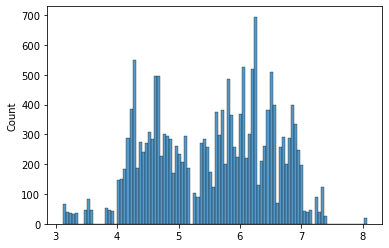

In [8]:
# histogram of the pH optima
sns.histplot(pH_optima, bins=100)

#### Notes
Switching to a running mean fixed the endpoint pH problems

<AxesSubplot:xlabel='pH.water', ylabel='Count'>

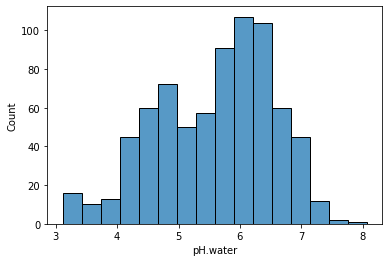

In [9]:
# plot the pH values from the metadata
sns.histplot(md['pH.water'])

In [10]:
# get the results of matching the ASVs to GTDB
to_gtdb = pd.read_csv('/data/mhoffert/optimum_ph/analysis/gtdb_map/Oliverio_2020a_to_GTDB_bac120_r202.tsv', sep='\t', header=None)

In [11]:
# subset to ASVs in the final table
to_gtdb = to_gtdb[to_gtdb[0].isin(otus_norm.index)]

In [12]:
# how many ASVs matched?
len(to_gtdb[0].unique())

8776

In [13]:
# how many genomes matched?
len(to_gtdb[1].unique())

2325

In [14]:
# get a list of genomes which had 1 ASV match
gb_genome = to_gtdb.groupby(1).apply(lambda x: list(x[0]))
# subset to genomes with a single ASV match
single_asv_genomes = gb_genome[gb_genome.apply(len) == 1]
# also get genomes with multiple ASVs, but only ones with a
# standard deviation of pH less than 0.3 (arbitrarily)
gb_genome_ph_std = gb_genome.apply(lambda x: np.std(pH_optima.loc[x]))
consistent_multiple_asv_genomes = gb_genome_ph_std[gb_genome_ph_std < 0.3]

#### Notes
I just picked the genomes with only 1 ASV match, so there's only 1 measured pH optimum for that genome. If there are multiple ASVs which match a genome, I'm picking only the genomes where the different pH estimates for matching ASVs are close together.

In [15]:
# make a version with ids not containing the RF_ prefix
# reformat genome ids from RS_GCA_000719105.1 to GCA_000719105.1
gb_genome_reformat = gb_genome.copy(deep=True)
gb_genome_reformat.index = ['_'.join(s.split('_')[1:]) for s in gb_genome_reformat.index]

In [16]:
# make a combined list
matched_genomes = list(set(list(single_asv_genomes.index) + list(consistent_multiple_asv_genomes.index)))

In [17]:
# reformat genome ids from RS_GCA_000719105.1 to GCA_000719105.1
matched_genomes_noprefix = ['_'.join(s.split('_')[1:]) for s in matched_genomes]

In [18]:
len(matched_genomes)

1329

In [19]:
# get the pH prediction for each genome
genome_ph_preds = pd.Series()
for m in matched_genomes:
    new_m = '_'.join(m.split('_')[1:])
    genome_ph_preds.loc[new_m] = pH_optima.loc[gb_genome.loc[m]].mean()

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


## Building ML methods from k-mers
Although I don't think that k-mers are the most functionally informative method to use because I'd expect the euclidean distance bewtween two genome's k-mer profiles to be correlated with the phylogenetic distance between the profiles - so the model is kind of being built off of taxonomic / phylogenetic information. However, using k-mers is pretty common, and a lot faster than annotating all the genomes with Pfam. So I'm going to test some models to predict pH from k-mer counts data first as a proof of concept.

In [20]:
"""
get paths to GTDB genomes to get k-mer counts
"""
genome_paths = pd.read_csv("/data/mhoffert/genomes/GTDB/gtdb_genomes_reps_r202/genome_paths.tsv", sep=' ', header=None)
genome_paths = genome_paths.rename(columns={0:'name', 1:'path'})
genome_paths['path_reformat'] = genome_paths['path'].apply(lambda x: f'/data/mhoffert/genomes/GTDB/gtdb_genomes_reps_r202/{x}')
genome_paths['genome'] = genome_paths['name'].apply(lambda x: x.split('_genomic')[0])
genome_paths['full'] = genome_paths.apply(lambda row: f'{row["path_reformat"]}{row["name"]}', axis=1)
genome_paths = genome_paths.set_index('genome')

In [21]:
genome_paths.loc[matched_genomes_noprefix]

,name,path,path_reformat,full
genome,,,,
GCF_004348415.1,GCF_004348415.1_genomic.fna.gz,GCF/004/348/415/,/data/mhoffert/genomes/GTDB/gtdb_genomes_reps_...,/data/mhoffert/genomes/GTDB/gtdb_genomes_reps_...
GCF_002944405.1,GCF_002944405.1_genomic.fna.gz,GCF/002/944/405/,/data/mhoffert/genomes/GTDB/gtdb_genomes_reps_...,/data/mhoffert/genomes/GTDB/gtdb_genomes_reps_...
GCF_004364125.1,GCF_004364125.1_genomic.fna.gz,GCF/004/364/125/,/data/mhoffert/genomes/GTDB/gtdb_genomes_reps_...,/data/mhoffert/genomes/GTDB/gtdb_genomes_reps_...
GCF_002198715.1,GCF_002198715.1_genomic.fna.gz,GCF/002/198/715/,/data/mhoffert/genomes/GTDB/gtdb_genomes_reps_...,/data/mhoffert/genomes/GTDB/gtdb_genomes_reps_...
GCF_003319095.1,GCF_003319095.1_genomic.fna.gz,GCF/003/319/095/,/data/mhoffert/genomes/GTDB/gtdb_genomes_reps_...,/data/mhoffert/genomes/GTDB/gtdb_genomes_reps_...
...,...,...,...,...
GCF_004137245.1,GCF_004137245.1_genomic.fna.gz,GCF/004/137/245/,/data/mhoffert/genomes/GTDB/gtdb_genomes_reps_...,/data/mhoffert/genomes/GTDB/gtdb_genomes_reps_...
GCF_011752565.1,GCF_011752565.1_genomic.fna.gz,GCF/011/752/565/,/data/mhoffert/genomes/GTDB/gtdb_genomes_reps_...,/data/mhoffert/genomes/GTDB/gtdb_genomes_reps_...
GCF_001591405.1,GCF_001591405.1_genomic.fna.gz,GCF/001/591/405/,/data/mhoffert/genomes/GTDB/gtdb_genomes_reps_...,/data/mhoffert/genomes/GTDB/gtdb_genomes_reps_...


#### Notes
The below code takes about 20 minutes to run for the 1,300 genomes

In [24]:
"""
Construct k-mer counts for each genome we have pH measurements for
"""
kmer_counters = []
num_complete = 0
total = 1300
k = 6
# sample a number of genomes
sampled_genomes = sample(matched_genomes_noprefix, total)
# for each path
for path in genome_paths.loc[sampled_genomes, 'full']:
    perccomp = num_complete / total * 100
    fstr = f'{perccomp:.3f}%'
    display(fstr)
    clear_output(wait=True)
    with gzip.open(path, "rt") as handle:
        records = []
        for r in SeqIO.parse(handle, "fasta"):
            records.append(r)
    # construct a counter of k-mers
    for r, i in zip(records, range(len(records))):
        rlist = str(r.seq)
        rlist_kmer = [rlist[i:i+k] for i in range(0, len(rlist)-k+1)]
        if i == 0:
            c = Counter(rlist_kmer)
        else:
            c = c + Counter(rlist_kmer)
    kmer_counters.append(c)
    num_complete += 1

'99.923%'

In [25]:
# make count frequency data for ML models
kmers = [''.join(s) for s in itertools.product('ATGC', repeat=k)]
kmers_rf_data =  pd.DataFrame(kmer_counters, index=sampled_genomes).reindex(columns=kmers).fillna(0)
kmers_y_data = genome_ph_preds.loc[sampled_genomes]

In [65]:
kmers_rf_data_norm = kmers_rf_data.divide(kmers_rf_data.sum(1), 0)

## Random Forest test

In [67]:
# define a grid of parameters to test
n_trees = [100, 500, 1000]
depth = [1,3,5,10]
grid = pd.DataFrame(index=pd.MultiIndex.from_product([n_trees, depth], names=['n_trees', 'depth'])).reset_index()
grid.index.name = 'rep'
grid.head()

,n_trees,depth
rep,,
0,100,1
1,100,3
2,100,5
3,100,10
4,500,1


In [42]:
"""
Perform testing of different parameters
without CV or repetitions or anything fancy
I just want to know if the predictions are 100% garbage
"""
results = pd.Series()
for index, row in grid.iterrows():
    display(index / len(grid))
    clear_output(wait=True)

    regr = RandomForestRegressor(max_depth=row['depth'], 
                                 n_estimators=row['n_trees'], 
                                 bootstrap=True, 
                                 n_jobs=16,
                                 max_features=400,
                                 oob_score=True)
    regr.fit(kmers_rf_data.head(1000).values, kmers_y_data.head(1000).values)
    preds = regr.predict(kmers_rf_data.tail(300))
    mse = ((preds - kmers_y_data.tail(300)) ** 2).mean()
    results.loc[index] = mse

0.9166666666666666

In [80]:
# test on normalized k-mer counts
regr = RandomForestRegressor(max_depth=2, 
                             n_estimators=1000, 
                             bootstrap=True, 
                             n_jobs=16,
                             oob_score=True,
                             max_features=5,
                             max_samples=0.6)
regr.fit(kmers_rf_data_norm.head(1000).values, kmers_y_data.head(1000).values)
preds = regr.predict(kmers_rf_data.tail(300))
mse = ((preds - kmers_y_data.tail(300)) ** 2).mean()

In [81]:
mse

0.8817719045592499

<AxesSubplot:xlabel='n_trees', ylabel='result'>

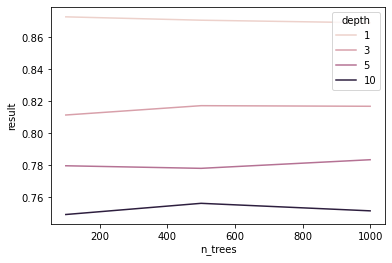

In [43]:
# plot performance using MSE as the loss function
sns.lineplot(data=pd.merge(results.rename('result'), grid, left_index=True, right_index=True), y='result', x='n_trees', hue='depth')

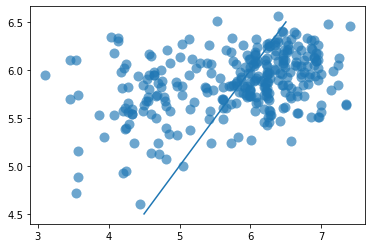

In [44]:
# just plot predictions vs actual
sns.scatterplot(y=preds, x=kmers_y_data.tail(300).values, alpha=0.65, s=100, linewidth=0)
plt.plot((4.5,6.5), (4.5,6.5))

In [45]:
spearmanr(preds, kmers_y_data.tail(300).values)

SpearmanrResult(correlation=0.34095591846421713, pvalue=1.3316771348803256e-09)

The predictions aren't good, but they aren't 100% garbage, which gives me hope we can actually do this

## Boosting test

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

In [47]:
from sklearn.model_selection import train_test_split

In [82]:
# define a grid of parameters to test
n_trees = [100,500,1000, 2000]
depth = [1,3,5,10,15]
learning_rate = [0.1, 0.01]
boosted_grid = pd.DataFrame(index=pd.MultiIndex.from_product([n_trees, depth, learning_rate], names=['n_trees', 'depth', 'rate'])).reset_index()
boosted_grid.index.name = 'rep'
boosted_grid.head()

,n_trees,depth,rate
rep,,,
0,100,1,0.10
1,100,1,0.01
2,100,3,0.10
3,100,3,0.01
4,100,5,0.10


In [ ]:
"""
Perform CV-free testing of different parameters
"""
boost_results = pd.Series()
for index, row in boosted_grid.iterrows():
    display(index / len(grid))
    clear_output(wait=True)
    print(row)
    regr = XGBRegressor(max_depth=int(row['depth']), 
                         n_estimators=int(row['n_trees']), 
                         learning_rate=row['rate'])
    regr.fit(kmers_rf_data.astype(int).head(1000).values, kmers_y_data.head(1000).values)
    preds = regr.predict(kmers_rf_data.tail(300))
    mse = ((preds - kmers_y_data.tail(300)) ** 2).mean()
    boost_results.loc[index] = mse

n_trees    2000.00
depth        15.00
rate          0.01
Name: 39, dtype: float64


In [118]:
regr.predict(kmers_rf_data.tail(300))

array([5.2595444, 5.7382555, 5.4171557, 6.252629 , 5.552281 , 5.4246373,
       6.2533307, 4.9493523, 5.403475 , 5.9030366, 5.142088 , 6.017497 ,
       5.896805 , 5.3896294, 5.6965585, 6.0855646, 6.0357137, 6.0469933,
       5.3756003, 6.0637417, 5.7166944, 5.8979683, 5.99583  , 5.3195143,
       5.9050546, 4.06354  , 5.81195  , 5.255494 , 5.841297 , 5.81096  ,
       4.959969 , 6.445593 , 5.748142 , 5.3353767, 5.943613 , 6.6144896,
       5.9470544, 6.0089693, 6.167863 , 5.3002167, 6.248824 , 5.562599 ,
       5.521138 , 5.262222 , 5.888185 , 5.8611283, 5.418357 , 4.5828023,
       5.3585553, 5.9209166, 6.113533 , 5.6363583, 5.786273 , 5.7326603,
       5.1914043, 5.9250064, 4.9958167, 6.7987533, 5.845148 , 6.038453 ,
       6.6824107, 6.4928365, 5.903044 , 6.135102 , 5.8332195, 5.8341985,
       6.7168703, 6.0541873, 5.208086 , 6.2609987, 5.604011 , 6.1717334,
       5.91127  , 6.2330213, 5.285799 , 5.9235883, 6.280694 , 5.7441206,
       5.2977304, 6.339983 , 6.0067396, 6.2681684, 

In [116]:
mse

0.8084726668417997

<AxesSubplot:xlabel='n_trees', ylabel='result'>

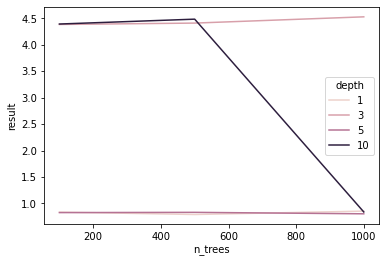

In [109]:
# plot performance using MSE as the loss function
sns.lineplot(data=pd.merge(boost_results.rename('result'), grid, left_index=True, right_index=True), y='result', x='n_trees', hue='depth')

Something is messed up in the code

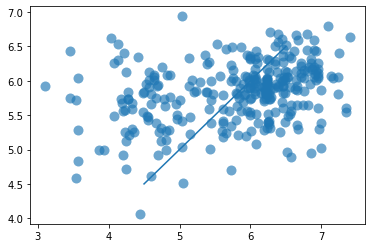

In [110]:
# just plot predictions vs actual
sns.scatterplot(y=preds, x=kmers_y_data.tail(300).values, alpha=0.65, s=100, linewidth=0)
plt.plot((4.5,6.5), (4.5,6.5))

In [113]:
spearmanr(preds, kmers_y_data.tail(300).values)

SpearmanrResult(correlation=0.31559464071175647, pvalue=2.3120588745623006e-08)

# Done

In [390]:
genome_md = pd.read_csv('/data/mhoffert/genomes/GTDB/bac120_metadata_r202.tsv', sep='\t', index_col=0, low_memory=False)

In [394]:
genome_md['acc_reformat'] = genome_md.apply(lambda row: '_'.join(row.name.split('_')[1:]), axis=1)

In [396]:
genome_md_acc_reformat = genome_md.reset_index().set_index('acc_reformat')

In [399]:
genome_md.columns.values

array(['ambiguous_bases', 'checkm_completeness', 'checkm_contamination',
       'checkm_marker_count', 'checkm_marker_lineage',
       'checkm_marker_set_count', 'checkm_strain_heterogeneity',
       'coding_bases', 'coding_density', 'contig_count', 'gc_count',
       'gc_percentage', 'genome_size', 'gtdb_genome_representative',
       'gtdb_representative', 'gtdb_taxonomy', 'gtdb_type_designation',
       'gtdb_type_designation_sources', 'gtdb_type_species_of_genus',
       'l50_contigs', 'l50_scaffolds', 'longest_contig',
       'longest_scaffold', 'lsu_23s_contig_len', 'lsu_23s_count',
       'lsu_23s_length', 'lsu_23s_query_id', 'lsu_5s_contig_len',
       'lsu_5s_count', 'lsu_5s_length', 'lsu_5s_query_id',
       'lsu_silva_23s_blast_align_len', 'lsu_silva_23s_blast_bitscore',
       'lsu_silva_23s_blast_evalue', 'lsu_silva_23s_blast_perc_identity',
       'lsu_silva_23s_blast_subject_id', 'lsu_silva_23s_taxonomy',
       'mean_contig_length', 'mean_scaffold_length', 'mimag_high_q

SpearmanrResult(correlation=0.030570327790717958, pvalue=0.2645233167295808)


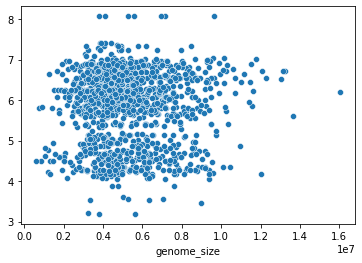

SpearmanrResult(correlation=0.048685097565166924, pvalue=0.07547615329314648)


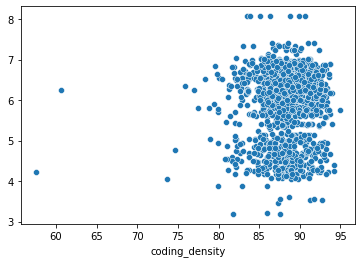

SpearmanrResult(correlation=0.06346395113586907, pvalue=0.020442842068291153)


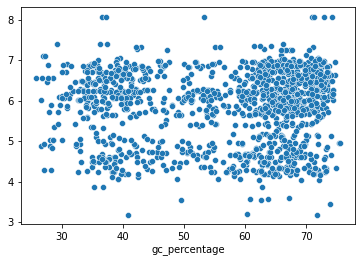

SpearmanrResult(correlation=0.0969777138989624, pvalue=0.0003895655709569109)


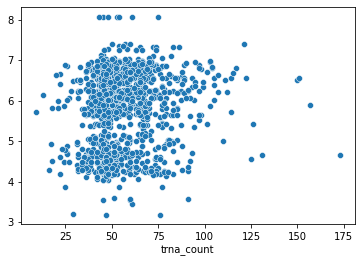

SpearmanrResult(correlation=0.030570327790717958, pvalue=0.2645233167295808)


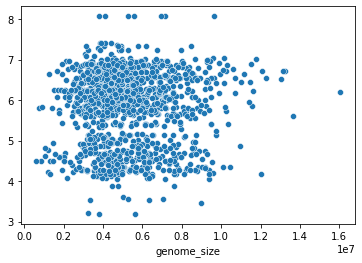

In [403]:
variables = ['genome_size', 'coding_density', 'gc_percentage', 'trna_count', 'genome_size']
for v in variables:
    x = genome_md_acc_reformat.loc[matched_genomes_noprefix, v]
    y = genome_ph_preds
    sns.scatterplot(x=x, y=y)
    print(spearmanr(x.reindex(y.index), y))
    plt.show()

In [237]:
precomputed = 0
annot_df_list = []
rf_ph_data = pd.Series()
for g in glob.glob('/data/mhoffert/geosmin/analysis/anvio_workflow/cromwell_streptomyces/*interpro.tsv'):
    genome = g.split('/')[-1].split('_interpro')[0]
    if genome in matched_genomes_noprefix:
        rf_ph_data.loc[genome] = pH_optima.loc[gb_genome_reformat.loc[genome]].mean()
        precomputed += 1
        # read annotations
        annots = pd.read_csv(g, sep='\t', header=None)
        # get the set of Pfam domains called in this genome
        genome_annots = annots[annots[3].eq('Pfam')][4].unique()
        # make an unstack-able dataframe
        tuples = [(genome, g) for g in genome_annots]
        annot_df = pd.DataFrame(index=pd.MultiIndex.from_tuples(tuples)).assign(present=True)
        # add to list
        annot_df_list.append(annot_df)
        display(precomputed)
        clear_output(wait=True)

64

In [238]:
# combine the df for each genome: unstack
rf_input_data = pd.concat(annot_df_list).unstack()

In [239]:
rf_input_data = rf_input_data.loc[:, rf_input_data.sum() != rf_input_data.shape[0]].replace({True:1,np.nan:0})

In [240]:
rf_input_data.head()

present                                                  \
                PF00011 PF00016 PF00022 PF00023 PF00026 PF00034 PF00036   
GCA_003719395.1       1       0       0       0       0       0       1   
GCA_014645815.1       0       0       0       0       0       1       0   
GCA_014645895.1       1       0       0       0       0       1       0   
GCA_014647675.1       1       0       0       0       0       1       0   
GCA_014649035.1       1       0       1       1       0       1       0   

                                         ...                                  \
                PF00041 PF00042 PF00045  ... PF20118 PF20120 PF20128 PF20129   
GCA_003719395.1       1       1       0  ...       0       0       0       0   
GCA_014645815.1       1       1       0  ...       0       0       1       0   
GCA_014645895.1       1       1       0  ...       0       0       0       0   
GCA_014647675.1       0       1       0  ...       0       1       0       0   
GCA_014649035.1       1       1       0  ...       0       0       1       0   

                                                                 
                PF20131 PF20137 PF20138 PF20139 PF20148 PF20159  
GCA_003719395.1       1       0       0       0       0       1  
GCA_014645815.1       0       0       0       1       1       0  
GCA_014645895.1       0       0       0       0       1       0  
GCA_014647675.1       0       0       0       1       1       0  
GCA_014649035.1       0       0       0       0       1       0  

[5 rows x 3061 columns]

In [125]:
regr.oob_score_

-0.060377219758215306

In [126]:
len(regr.feature_importances_)

3029

In [ ]:
# construct the 

In [13]:
# Unused placeholder code
# clusters = pd.read_csv('/home/michaelhoffert/phylogenetic/cluster_genome_norfs.tsv.gz', sep='\t')
# subset_clusters = clusters[clusters.domain.eq('B') & clusters.genome.isin(to_gtdb[1].unique())]
# clusters_wide = subset_clusters.set_index(['cl_name', 'genome'])['n'].unstack().fillna(0)
# clusters_wide.shape
# clusters_wide.head()

# To do
* Refine the optimum pH assignment method
* Annotate all GTDB genomes with Pfam (which would be helpful for the geosmin project)
* make the ML input data for all GTDB genomes
* test an ML model  
Noah wants to do a random forest because it has feature importance but I think a deep neural network will be better because I have no clue what features to expect to be information and I'd rather have better predictive performance at this point.

In [455]:
# testing a ML model, method
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

ModuleNotFoundError: No module named 'keras'

In [ ]:
# first neural network with keras make predictions

# load the dataset
dataset = loadtxt('pima-indians-diabetes.csv', delimiter=',')
# split into input (X) and output (y) variables
X = dataset[:,0:8]
y = dataset[:,8]
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X, y, epochs=150, batch_size=10, verbose=0)
# make class predictions with the model
predictions = (model.predict(X) > 0.5).astype(int)
# summarize the first 5 cases
for i in range(5):
	print('%s => %d (expected %d)' % (X[i].tolist(), predictions[i], y[i]))